# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [45]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report


In [32]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [34]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [35]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [36]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [37]:
def get_value_counts(df, column=None):
    if column:
        print(f"\nValue counts for {column}:")
        print(df[column].value_counts())
    else:
        for column in df.columns:
            print(f"\nValue counts for {column}:")
            print(df[column].value_counts())
get_value_counts(df)


Value counts for num_passengers:
1    31352
2    12804
3     2941
4     1784
5      561
6      289
7      114
8       89
9       66
Name: num_passengers, dtype: int64

Value counts for sales_channel:
Internet    44382
Mobile       5618
Name: sales_channel, dtype: int64

Value counts for trip_type:
RoundTrip     49497
OneWay          387
CircleTrip      116
Name: trip_type, dtype: int64

Value counts for purchase_lead:
1      685
2      670
6      653
7      638
5      615
      ... 
641      1
471      1
614      1
463      1
867      1
Name: purchase_lead, Length: 470, dtype: int64

Value counts for length_of_stay:
6      7757
5      7286
4      5655
3      2839
17     1849
       ... 
226       1
778       1
610       1
308       1
356       1
Name: length_of_stay, Length: 335, dtype: int64

Value counts for flight_hour:
8     3165
12    3163
9     3132
7     3126
11    3110
13    3101
10    3085
6     3050
5     2851
4     2843
14    2833
3     2655
2     2642
15    2234
1     2089

In [38]:
df.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete'],
      dtype='object')

In [39]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

## EDA 

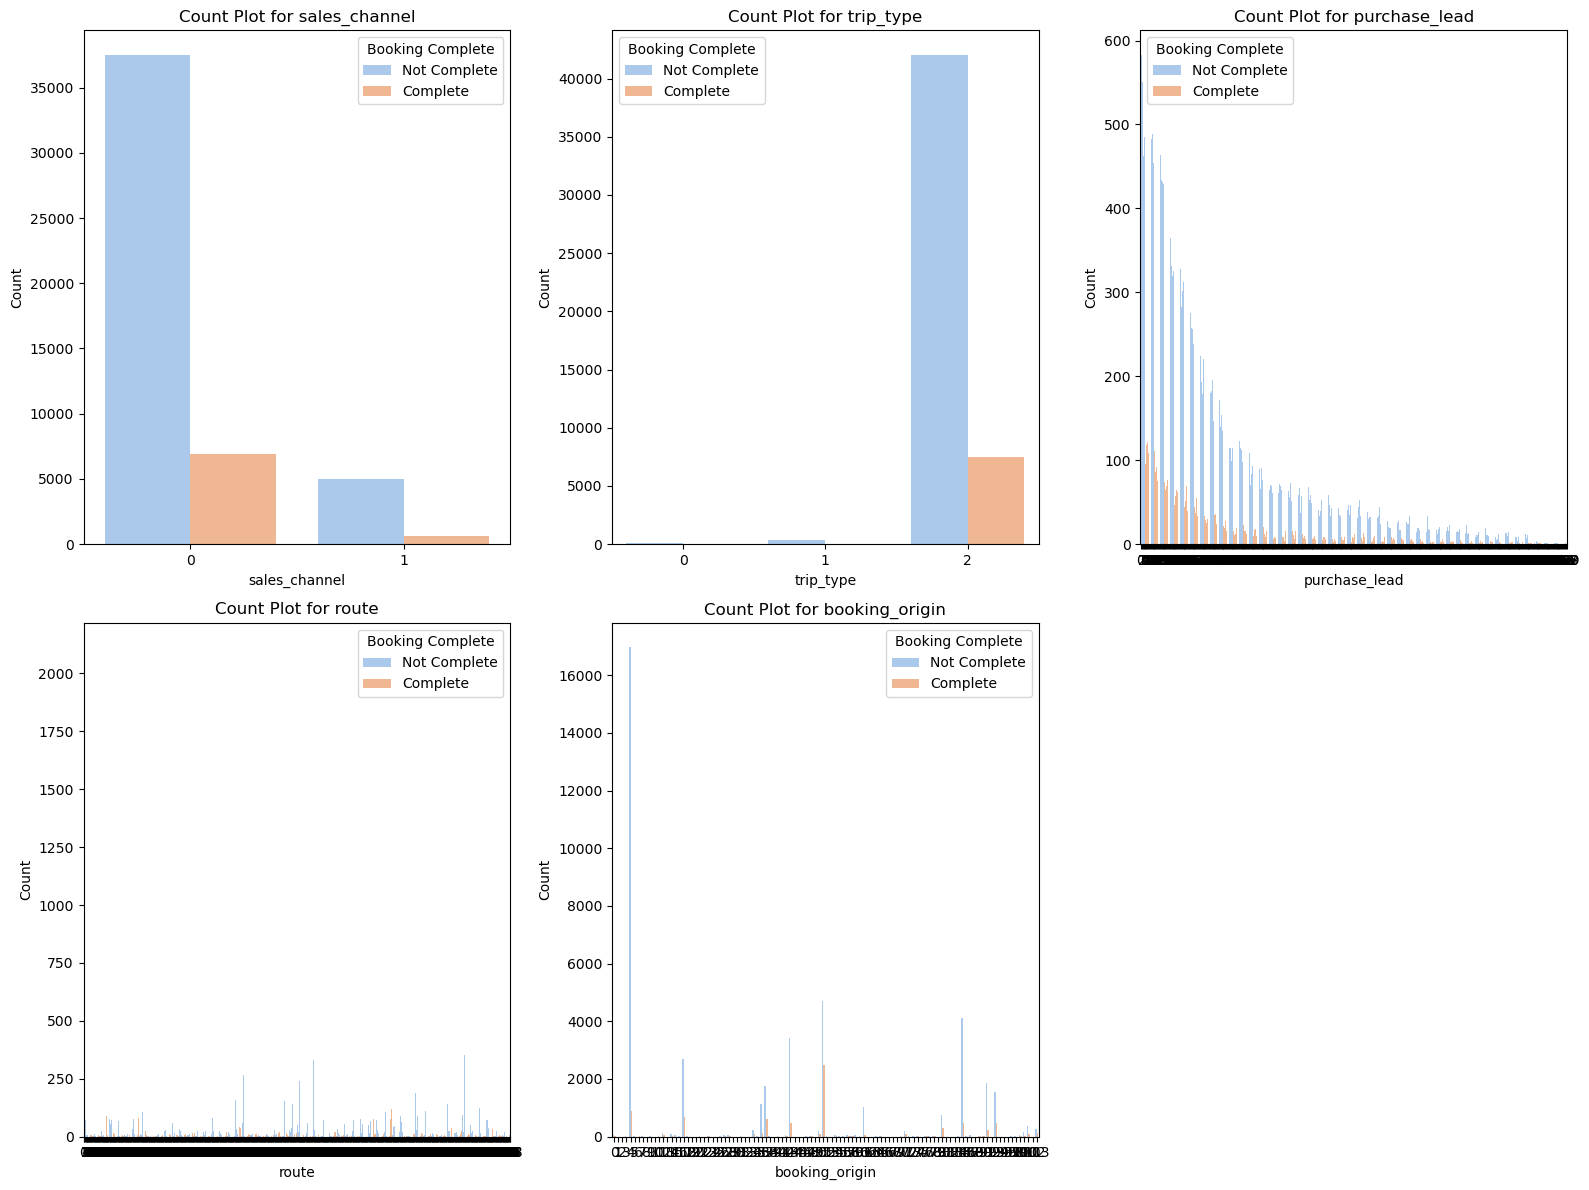

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


# Encode categorical variables (convert categorical data into numerical form)
label_encoder = LabelEncoder()
categorical_columns = ['sales_channel', 'trip_type', 'purchase_lead','route', 'booking_origin']
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Plot count plots for each categorical variable against the target variable
plt.figure(figsize=(16, 12))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=col, hue='booking_complete', data=df, palette='pastel')
    plt.title(f'Count Plot for {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Booking Complete', labels=['Not Complete', 'Complete'])

plt.tight_layout()
plt.show()


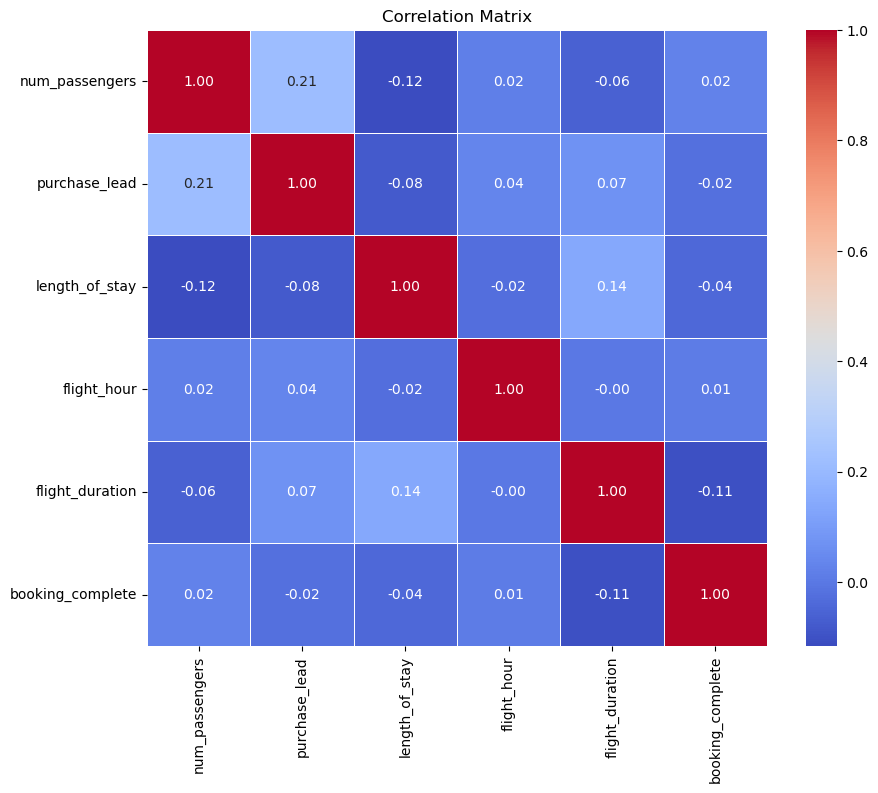

Correlation with the target variable ('booking_complete'):
num_passengers     0.024116
purchase_lead     -0.022305
length_of_stay    -0.042408
flight_hour        0.007127
flight_duration   -0.106266
Name: booking_complete, dtype: float64


In [41]:
# Extract the numerical features and the target variable
numerical_features = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
target_variable = 'booking_complete'
# Calculate the correlation coefficients
correlation_matrix = df[numerical_features + [target_variable]].corr()
# Visualize the correlations using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()
# Print correlation coefficients with the target variable
print("Correlation with the target variable ('booking_complete'):")
print(correlation_matrix[target_variable].drop(target_variable))

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Define numerical features and target variable
numerical_features = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
target_variable = 'booking_complete'

# Split the data into features (X) and the target variable (y)
X = df[numerical_features]
y = df[target_variable]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict the target variable on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance using accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8326

Confusion Matrix:
[[8190  330]
 [1344  136]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      8520
           1       0.29      0.09      0.14      1480

    accuracy                           0.83     10000
   macro avg       0.58      0.53      0.52     10000
weighted avg       0.78      0.83      0.79     10000



## Random Forest

In [44]:
target_variable = 'booking_complete'
# Split the data into features (X) and the target variable (y)
X = df.drop(target_variable, axis=1)
y = df[target_variable]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize the model
rf_model = RandomForestClassifier(random_state=42)
# Train the model on the training data
rf_model.fit(X_train, y_train)
# Predict the target variable on the test set
y_pred = rf_model.predict(X_test)
# Evaluate the model's performance using accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")

Accuracy: 0.8541

Classification Report:


## Grid Search

In [46]:
# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],      # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
}
# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')
# Train the model on the training data and perform grid search
grid_search.fit(X_train, y_train)
# Get the best model and its hyperparameters
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_
# Predict the target variable on the test set using the best model
y_pred = best_rf_model.predict(X_test)
# Evaluate the model's performance using accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("\nClassification Report:")

Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.8554

Classification Report:


In [47]:
# Assuming you have already trained the best_rf_model as obtained from the grid search
# Get feature importances
feature_importances = best_rf_model.feature_importances_
# Get the list of feature names
feature_names = X_train.columns
# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
# Sort the DataFrame in descending order of feature importances
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Print or display the feature importances
print("Feature Importances:")
print(feature_importance_df)

Feature Importances:
                  Feature  Importance
3           purchase_lead    0.183204
7                   route    0.152632
5             flight_hour    0.134099
4          length_of_stay    0.124190
8          booking_origin    0.123070
6              flight_day    0.086938
12        flight_duration    0.074293
0          num_passengers    0.050060
11  wants_in_flight_meals    0.022536
10   wants_preferred_seat    0.017554
9     wants_extra_baggage    0.016637
1           sales_channel    0.012823
2               trip_type    0.001965


## Feature Importance

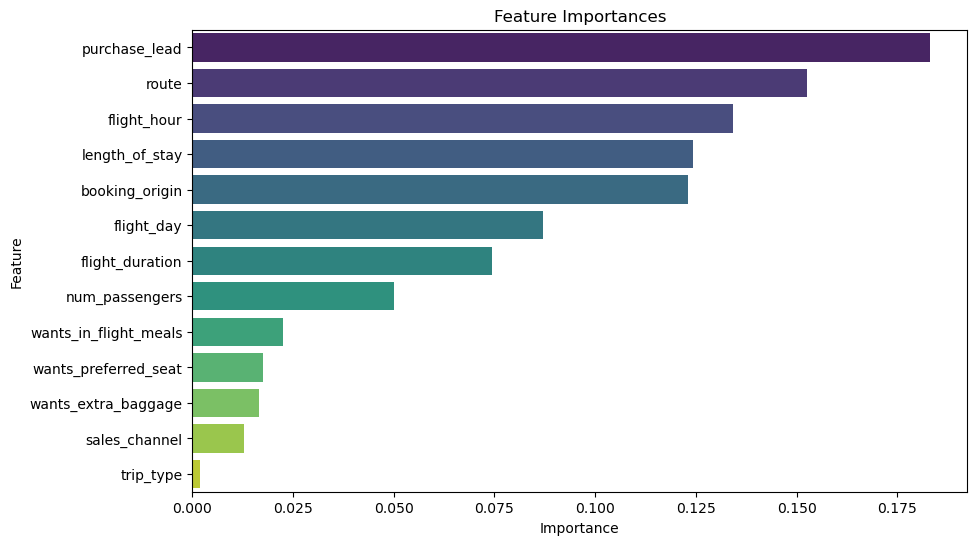

In [49]:
# Create a DataFrame for feature importances
data = {
    'Feature': ['purchase_lead', 'route', 'flight_hour', 'length_of_stay', 'booking_origin',
                'flight_day', 'flight_duration', 'num_passengers', 'wants_in_flight_meals',
                'wants_preferred_seat', 'wants_extra_baggage', 'sales_channel', 'trip_type'],
    'Importance': [0.183204, 0.152632, 0.134099, 0.124190, 0.123070, 0.086938, 0.074293, 0.050060,
                   0.022536, 0.017554, 0.016637, 0.012823, 0.001965]
}
feature_importances_df = pd.DataFrame(data)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()
